In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch


In [2]:
num = 68
# 29,68,101,145,152,159,174,201,232,250
df = pd.read_csv(f'./SMAI - AQ2/CSV/TLBR_{num}.csv')
img = cv2.imread(f'./SMAI - AQ2/images/{num}.jpg')
df

,Unnamed: 0,Top-Left,Bottom-Right,Id
0,0,"[290, 85]","[435, 147]",0
1,1,"[563, 82]","[730, 147]",1
2,2,"[744, 92]","[940, 140]",2
3,3,"[1163, 92]","[1184, 147]",3
4,4,"[1218, 79]","[1344, 157]",4
...,...,...,...,...
493,493,"[1566, 3264]","[1740, 3315]",493
494,494,"[1762, 3261]","[1851, 3315]",494
495,495,"[1958, 3261]","[2100, 3312]",495
496,496,"[2120, 3250]","[2163, 3315]",496


In [3]:
def visualize_bboxes(img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)

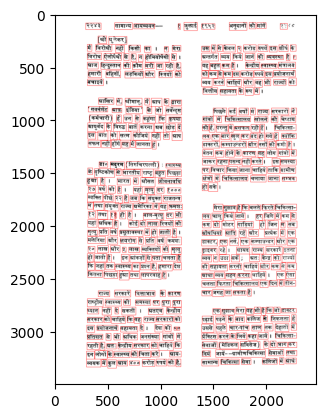

In [4]:
visualize_bboxes(img)

---

In [5]:
# forming a new dataframe(centers) with centers of rectangles

col = ['CenterX', 'CenterY']
data = {column: [] for column in col}

for index, rows in df.iterrows():
    # print(rows)
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    CenterX = ((top_left[0] + bottom_right[0])/2)
    CenterY = ((top_left[1] + bottom_right[1])/2)
    data['CenterX'].append(CenterX)
    data['CenterY'].append(CenterY)

centers = pd.DataFrame(data)

In [6]:
X = centers['CenterX'].values.reshape(-1,1)
linkage_matrix = sch.linkage(X, method='single')

optimal_clusters = 0
max_silhouette_score = -1
max_components = 20

for k in range(2, max_components+1):
    labels = sch.fcluster(linkage_matrix, k, criterion='maxclust')
    silhouette_avg = silhouette_score(X, labels)
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_clusters = k

print("Optimal Number of Clusters :", optimal_clusters)
horizontal_threshold = linkage_matrix[-(optimal_clusters - 1), 2]
print("Horizontal Threshold Distance:", horizontal_threshold)


Optimal Number of Clusters : 2
Horizontal Threshold Distance: 135.5


In [7]:
Y = centers['CenterY'].values.reshape(-1,1)
linkage_matrix = sch.linkage(Y, method='single')

optimal_clusters = 0
max_silhouette_score = -1
max_components = 20

for k in range(2, max_components+1):
    labels = sch.fcluster(linkage_matrix, k, criterion='maxclust')
    silhouette_avg = silhouette_score(Y, labels)
    if silhouette_avg > max_silhouette_score:
        max_silhouette_score = silhouette_avg
        optimal_clusters = k

print("Optimal Number of Clusters:", optimal_clusters)
vertical_threshold = linkage_matrix[-(optimal_clusters - 1), 2]
print("Vertical Threshold Distance:", vertical_threshold)

Optimal Number of Clusters: 20
Vertical Threshold Distance: 63.0


In [8]:
# putting the direction of box with min distance in the dataframe
columns = ['Id', 'Top-Left', 'Bottom-Right', 'Top', 'Left', 'Bottom', 'Right', 'Top_box', 'Bottom_box', 'Left_box', 'Right_box', 'Center']
data = {column: [] for column in columns}

for index, rows in df.iterrows():

    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    top = [(top_left[0] + bottom_right[0])/2, top_left[1]]
    left = [top_left[0], (top_left[1] + bottom_right[1])/2]
    bottom = [(top_left[0] + bottom_right[0])/2, bottom_right[1]]
    right = [bottom_right[0], (top_left[1] + bottom_right[1])/2]
    center = ((top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2)

    data['Id'].append(rows['Id'])
    data['Top-Left'].append(top_left)
    data['Bottom-Right'].append(bottom_right)
    data['Top'].append(top)
    data['Left'].append(left)
    data['Bottom'].append(bottom)
    data['Right'].append(right)
    data['Center'].append(center)


for ind, row in df.iterrows():
    min_dist = 1e9
    box_Id = -1
    for ind2, row2 in df.iterrows():
        # data['Center'][ind][0] > data['Center'][ind2][0] means the box2 is left to the current box1
        if(ind != ind2 and data['Center'][ind][0] > data['Center'][ind2][0]):
            distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
            distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
            if(distX < min_dist and distX <= horizontal_threshold and distY <= vertical_threshold):
                min_dist = distX
                box_Id = row2['Id']
    if(box_Id != -1):
        data['Left_box'].append([min_dist, box_Id])
    else:
        data['Left_box'].append([-1, 0])  # to remove connection

for ind, row in df.iterrows():
    min_dist = 1e9
    box_Id = -1
    for ind2, row2 in df.iterrows():
        # data['Center'][ind][0] < data['Center'][ind2][0] means the box2 is right to the current box1
        if(ind != ind2 and data['Center'][ind][0] < data['Center'][ind2][0]):
            distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
            distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
            if(distX < min_dist and distX <= horizontal_threshold and distY <= vertical_threshold):
                min_dist = distX
                box_Id = row2['Id']
    if(box_Id != -1):
        data['Right_box'].append([min_dist, box_Id])
    else:
        data['Right_box'].append([-1, 0])  # to remove connection

for ind, row in df.iterrows():
    min_dist = 1e9
    box_Id = -1
    for ind2, row2 in df.iterrows():
        # data['Center'][ind][1] > data['Center'][ind2][1] means the box2 is below the current box1
        if(ind != ind2 and data['Center'][ind][1] > data['Center'][ind2][1]):
            distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
            distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
            if(distY < min_dist and distY <= vertical_threshold and distX <= horizontal_threshold):
                min_dist = distY
                box_Id = row2['Id']
    if(box_Id != -1):
        data['Bottom_box'].append([min_dist, box_Id])
    else:
        data['Bottom_box'].append([-1, 0])  # to remove connection

for ind, row in df.iterrows():
    min_dist = 1e9
    box_Id = -1
    for ind2, row2 in df.iterrows():
        # data['Center'][ind][1] < data['Center'][ind2][1] means the box2 is above the current box1
        if(ind != ind2 and data['Center'][ind][1] < data['Center'][ind2][1]):
            distX = abs(data['Center'][ind][0] - data['Center'][ind2][0])
            distY = abs(data['Center'][ind][1] - data['Center'][ind2][1])
            if(distY < min_dist and distY <= vertical_threshold and distX <= horizontal_threshold):
                min_dist = distY
                box_Id = row2['Id']
    if(box_Id != -1):
        data['Top_box'].append([min_dist, box_Id])
    else:
        data['Top_box'].append([-1, 0]) # to remove connection

    
euclidean = pd.DataFrame(data)
euclidean

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Top_box,Bottom_box,Left_box,Right_box,Center
0,0,"(290, 85)","(435, 147)","[362.5, 85]","[290, 116.0]","[362.5, 147]","[435, 116.0]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]","(362.5, 116.0)"
1,1,"(563, 82)","(730, 147)","[646.5, 82]","[563, 114.5]","[646.5, 147]","[730, 114.5]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]","(646.5, 114.5)"
2,2,"(744, 92)","(940, 140)","[842.0, 92]","[744, 116.0]","[842.0, 140]","[940, 116.0]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]","(842.0, 116.0)"
3,3,"(1163, 92)","(1184, 147)","[1173.5, 92]","[1163, 119.5]","[1173.5, 147]","[1184, 119.5]","[-1, 0]","[1.5, 4]","[-1, 0]","[107.5, 4]","(1173.5, 119.5)"
4,4,"(1218, 79)","(1344, 157)","[1281.0, 79]","[1218, 118.0]","[1281.0, 157]","[1344, 118.0]","[1.5, 3]","[-1, 0]","[107.5, 3]","[-1, 0]","(1281.0, 118.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...
493,493,"(1566, 3264)","(1740, 3315)","[1653.0, 3264]","[1566, 3289.5]","[1653.0, 3315]","[1740, 3289.5]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]","(1653.0, 3289.5)"
494,494,"(1762, 3261)","(1851, 3315)","[1806.5, 3261]","[1762, 3288.0]","[1806.5, 3315]","[1851, 3288.0]","[-1, 0]","[-1, 0]","[-1, 0]","[-1, 0]","(1806.5, 3288.0)"
495,495,"(1958, 3261)","(2100, 3312)","[2029.0, 3261]","[1958, 3286.5]","[2029.0, 3312]","[2100, 3286.5]","[-1, 0]","[4.0, 496]","[-1, 0]","[112.5, 496]","(2029.0, 3286.5)"
496,496,"(2120, 3250)","(2163, 3315)","[2141.5, 3250]","[2120, 3282.5]","[2141.5, 3315]","[2163, 3282.5]","[4.0, 495]","[1.0, 497]","[112.5, 495]","[88.0, 497]","(2141.5, 3282.5)"


In [9]:
def make_connections(image):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      left_adjacent_id = int(row['Left_box'][1])
      right_adjacent_id = int(row['Right_box'][1])
      top_adjacent_id = int(row['Top_box'][1])
      bottom_adjacent_id = int(row['Bottom_box'][1])

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)



  return image_with_boxes

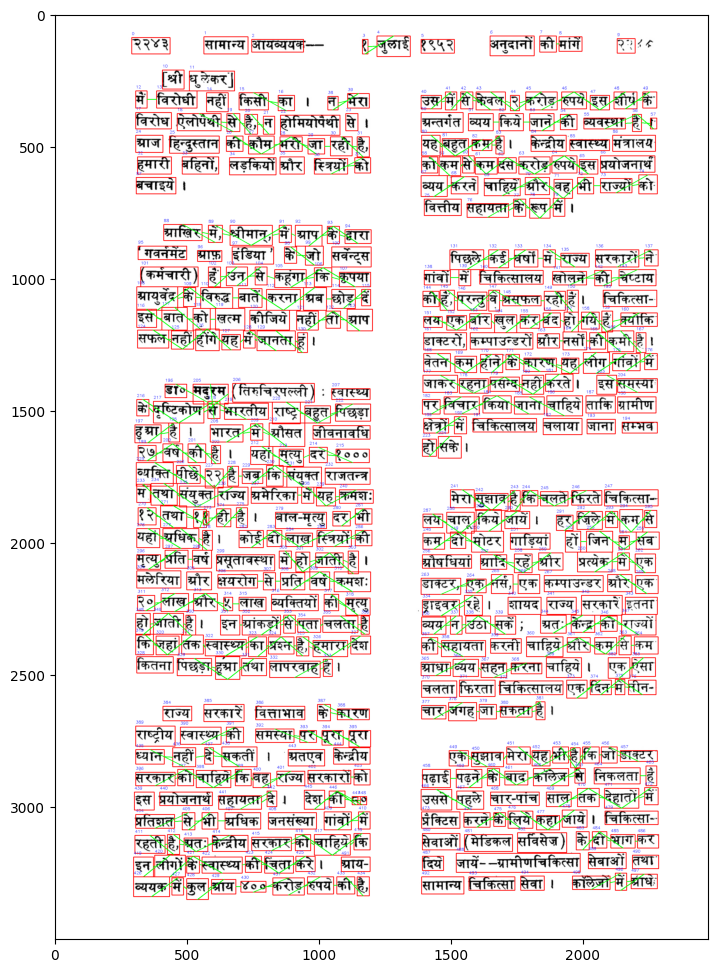

In [10]:
image_with_connections = make_connections(img)
plt.figure(figsize=(12, 12))
plt.imshow(image_with_connections)
plt.show()